In [5]:
import os

DATA_DIR = '/kaggle/input/animefacedataset'

In [6]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

In [7]:
img_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
transformer = T.Compose([T.Resize(img_size), T.CenterCrop(img_size), T.ToTensor(), T.Normalize(*stats)])
train_ds = ImageFolder(DATA_DIR, transform=transformer)

In [9]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [13]:
def show_batch(dl, nmax=64):
    for imgs, _ in dl:
        show_images(imgs, nmax)
        break

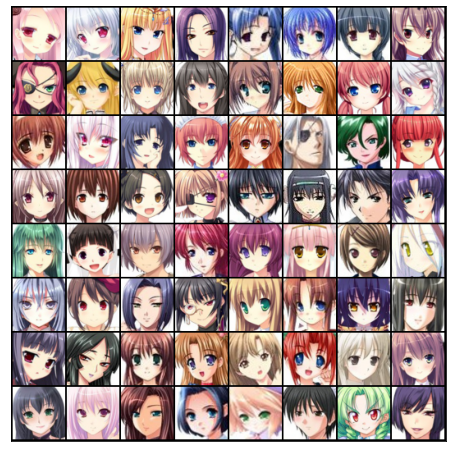

In [14]:
show_batch(train_dl)

In [15]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [16]:
device = torch.device('cuda')

train_dl = DeviceDataLoader(train_dl, device)

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

In [19]:
discriminator = to_device(discriminator, device)

In [20]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

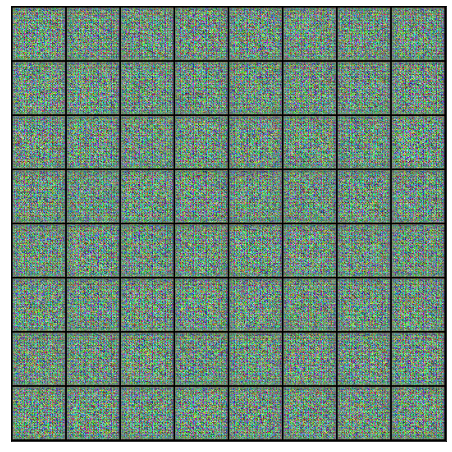

In [22]:
latent = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(latent)
show_images(fake_images)

In [23]:
generator = to_device(generator, device)

In [31]:
import torch.nn.functional as F

In [51]:
def train_discriminator(real_images, opt_func):
    opt_func.zero_grad()
    
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    loss = real_loss + fake_loss
    loss.backward()
    opt_func.step()
    return loss.item(), real_score, fake_score

In [54]:
def train_generator(opt_func):
    opt_func.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_func.step()
    return loss.item()

In [35]:
from torchvision.utils import save_image

In [36]:
os.makedirs('generated', exist_ok=True)

In [38]:
def save_samples(index, latents_tensor, show=True):
    fake_images = generator(latents_tensor)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join('generated', fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1, 2, 0))

In [40]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


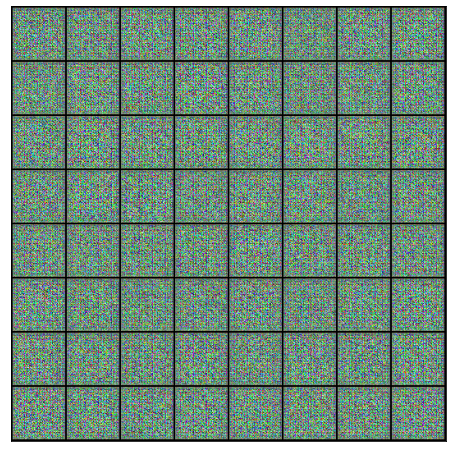

In [41]:
save_samples(0, fixed_latent)

In [42]:
from tqdm.notebook import tqdm

In [59]:
def fit(epochs, lr, start_index=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_func_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_func_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_func_d)
            loss_g = train_generator(opt_func_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        save_samples(epoch+start_index, fixed_latent, show=False)
        
    return losses_g, losses_d, real_scores, fake_scores

In [44]:
lr = 0.0002
epochs = 25

In [61]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 6.5369, loss_d: 0.2316, real_score: 0.9664, fake_score: 0.1635
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 10.5729, loss_d: 0.8474, real_score: 0.9936, fake_score: 0.4655
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.7829, loss_d: 0.1805, real_score: 0.8962, fake_score: 0.0503
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.9747, loss_d: 0.3678, real_score: 0.9930, fake_score: 0.2661
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.3372, loss_d: 0.1880, real_score: 0.8652, fake_score: 0.0281
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.9214, loss_d: 0.2714, real_score: 0.9715, fake_score: 0.1900
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 4.3083, loss_d: 0.1355, real_score: 0.9443, fake_score: 0.0712
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 3.9798, loss_d: 0.1780, real_score: 0.9393, fake_score: 0.1003
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 2.1597, loss_d: 0.6160, real_score: 0.7427, fake_score: 0.2076
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 3.7134, loss_d: 0.1828, real_score: 0.9032, fake_score: 0.0663
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.2431, loss_d: 0.2210, real_score: 0.9386, fake_score: 0.1288
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 4.2222, loss_d: 0.2160, real_score: 0.9387, fake_score: 0.1235
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.0809, loss_d: 0.2172, real_score: 0.8588, fake_score: 0.0377
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 4.3533, loss_d: 0.0879, real_score: 0.9472, fake_score: 0.0304
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.8606, loss_d: 0.1615, real_score: 0.9798, fake_score: 0.1242
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 3.8418, loss_d: 0.1126, real_score: 0.9169, fake_score: 0.0192
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 2.8167, loss_d: 0.1342, real_score: 0.8936, fake_score: 0.0113
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.0326, loss_d: 0.2048, real_score: 0.8460, fake_score: 0.0152
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.9439, loss_d: 0.0606, real_score: 0.9764, fake_score: 0.0338
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.1791, loss_d: 0.1780, real_score: 0.8941, fake_score: 0.0421
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.9815, loss_d: 0.0819, real_score: 0.9589, fake_score: 0.0324
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.5117, loss_d: 0.1508, real_score: 0.9480, fake_score: 0.0794
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.0327, loss_d: 0.1128, real_score: 0.9531, fake_score: 0.0559
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.8721, loss_d: 0.0722, real_score: 0.9688, fake_score: 0.0359
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 3.8017, loss_d: 0.1076, real_score: 0.9286, fake_score: 0.0279
Saving generated-images-0025.png


In [62]:
losses_g, losses_d, real_scores, fake_scores = history

In [64]:
torch.save(generator.state_dict(), '/kaggle/working/G.pth')
torch.save(discriminator.state_dict(), '/kaggle/working/D.pth')

In [66]:
from IPython.display import Image

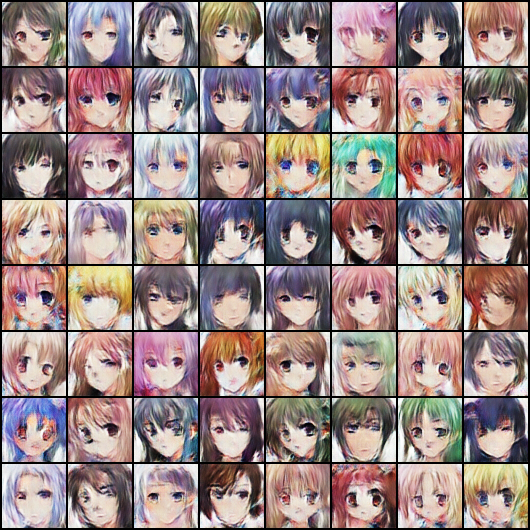

In [68]:
Image('/kaggle/working/generated/generated-images-0001.png')

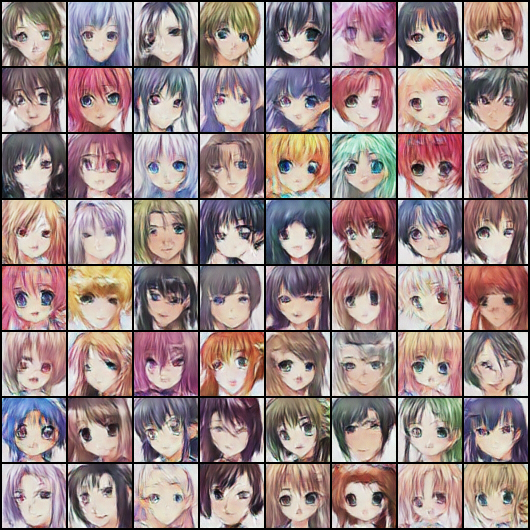

In [69]:
Image('/kaggle/working/generated/generated-images-0005.png')

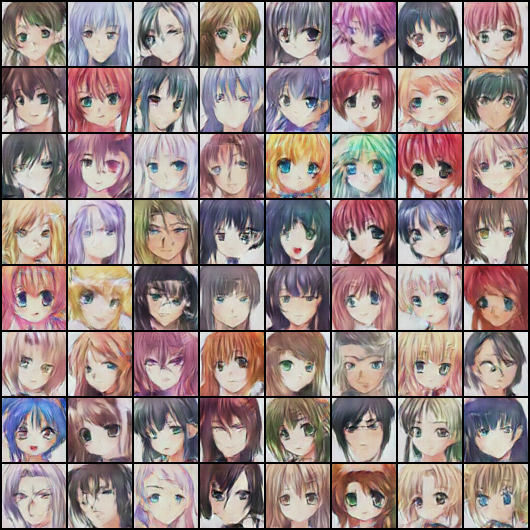

In [70]:
Image('/kaggle/working/generated/generated-images-0010.png')

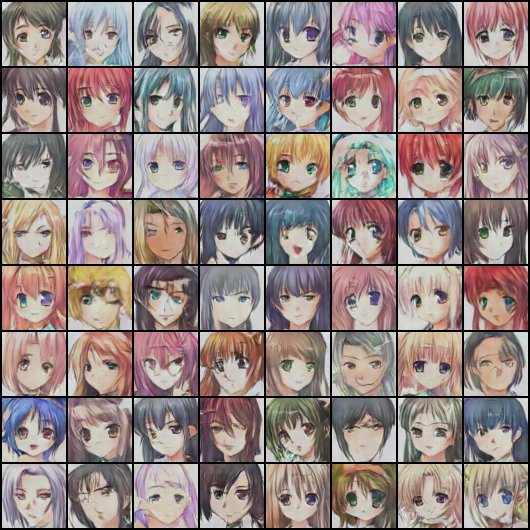

In [71]:
Image('/kaggle/working/generated/generated-images-0020.png')

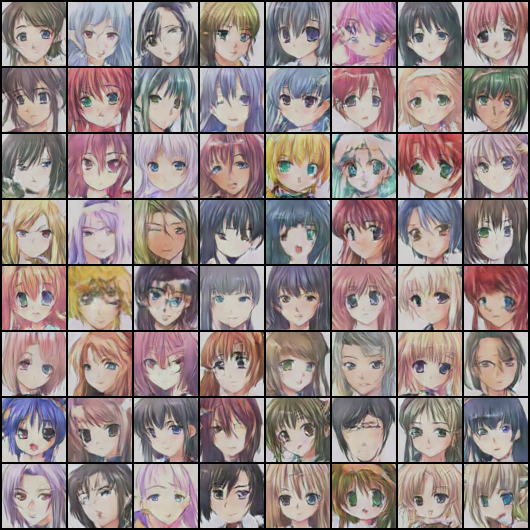

In [72]:
Image('/kaggle/working/generated/generated-images-0025.png')

In [73]:
import cv2

In [74]:
vid_name = '/kaggle/working/gans_training.mp4'
sample_dir = '/kaggle/working/generated'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (530, 530))
for fname in files:
    out.write(cv2.imread(fname))
out.release()

Text(0.5, 1.0, 'Losses')

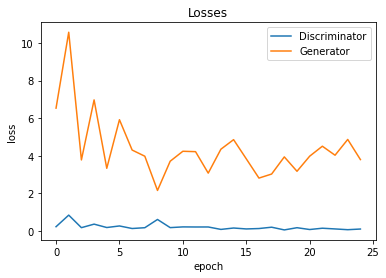

In [75]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

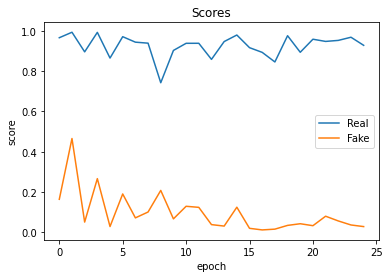

In [76]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')